# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [2]:
from unityagents import UnityEnvironment
import numpy as np
import random
import torch
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
from ddpg_agent_cc import Agent

import warnings
warnings.filterwarnings('ignore')

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
# Use this for single agent environment. no_graphics=True reduces the training time a bit.
# Remove no_graphics=True if you want to visualise the environment.
#env = UnityEnvironment(file_name="Reacher_Windows_x86_64_1/Reacher.exe", no_graphics=True, seed=0)

# Use this for 20 agent environment. no_graphics=True reduces the training time a bit.
env = UnityEnvironment(file_name="Reacher_Windows_x86_64_20/Reacher.exe")
#env = UnityEnvironment(file_name="Reacher_Windows_x86_64_20/Reacher.exe", no_graphics=True, seed=0)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print(states.shape)
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
(20, 33)
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
#while True:
for i_episode in range(1000):
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent). actions.shape = (20, 4)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent). next_states.shape = (20, 33)
    rewards = env_info.rewards                         # get reward (for each agent). len(rewards) = 20
    dones = env_info.local_done                        # see if episode finished. len(dones) = 20
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over {} agents) this episode: {}'.format(num_agents, np.mean(scores)))

Total score (averaged over 20 agents) this episode: 0.135499996971339


When finished, you can close the environment.

In [6]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

Episode 100	Average Score: 8.89
Episode 200	Average Score: 29.69
Episode 300	Average Score: 35.92
Episode 400	Average Score: 36.65
Episode 500	Average Score: 38.06

Environment solved in 400 episodes!	Average Score: 38.06


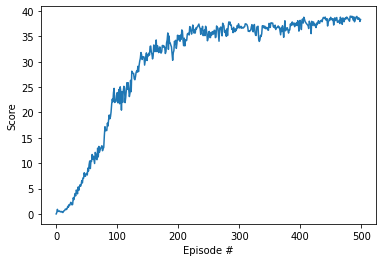

In [5]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=0)

def ddpg(n_episodes=500, max_t=1000, num_agents=20, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Deterministic Policy Gradient (DDPG).
    
    Params
    ======
        n_episodes (int): maximum number of training episodes.
        max_t (int): maximum number of timesteps per episode.
        num_agents (int): Number of parallel agents for collecting experience. It can be 1 or 20.
        eps_start (float): starting value of epsilon, for epsilon-greedy off-policy action selection.
        eps_end (float): minimum value of epsilon.
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon.
    """
    scores_all = []                       # list containing scores from each episode
    scores_window = deque(maxlen=100)     # last 100 scores
    eps = eps_start                       # initialize epsilon
    max_mean = -np.inf
    i_episode_solved = 0
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        states = env_info.vector_observations # get the current state (for each agent)
        agent.reset()                         # reset Noise
        scores_episode = np.zeros(num_agents) # initialize the score (for each agent)
        for t in range(max_t):
            actions = agent.act(states, eps, add_noise=True)  # select an action (for each agent)
            env_info = env.step(actions)[brain_name]     # send all actions to tne environment
            next_states = env_info.vector_observations   # get next state (for each agent)
            rewards = env_info.rewards                   # get reward (for each agent)
            dones = env_info.local_done                  # see if episode has finished (for each agent)
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done, num_agents) 
            states = next_states                         # roll over states to next time step
            scores_episode += rewards                    # update the score (for each agent)
            if np.any(dones):                            # exit loop if episode finished
                break 
        scores_window.append(np.mean(scores_episode))
        scores_all.append(np.mean(scores_episode))
        eps = max(eps_end, eps_decay*eps)                # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        
        #Store the weights corresponding to the best mean score
        curr_mean = np.mean(scores_window)
        if ((curr_mean >= 30.0) and (curr_mean > max_mean)):
            max_mean = curr_mean
            i_episode_solved = i_episode
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_cc.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_cc.pth')
            #break
    print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode_solved - 100, max_mean))
    return scores_all

scores = ddpg()
env.close()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()
fig.savefig("plots/training_plot_20.pdf", dpi=fig.dpi)

### Test the model on 20 agent environment

In [2]:
# Activate 20 agent environment
env = UnityEnvironment(file_name="Reacher_Windows_x86_64_20/Reacher.exe")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment for Test
num_agents = len(env_info.agents)
action_size = brain.vector_action_space_size
state_size = env_info.vector_observations.shape[1]

# Initialize an agent
agent = Agent(state_size=state_size, action_size=action_size, random_seed=0)

# load the weights from file
agent.actor_local.load_state_dict(torch.load('checkpoint_actor_cc.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic_cc.pth'))

states = env_info.vector_observations # get the current state (for each agent)
scores_episode = np.zeros(num_agents) # initialize the score (for each agent)

for t in range(1000):
    actions = agent.act(states, eps=1, add_noise=False)  # select an action (for each agent)
    env_info = env.step(actions)[brain_name]             # send all actions to tne environment
    next_states = env_info.vector_observations           # get next state (for each agent)
    rewards = env_info.rewards                           # get reward (for each agent)
    dones = env_info.local_done                          # see if episode has finished (for each agent)
    states = next_states                                 # roll over states to next time step
    scores_episode += rewards                            # update the score (for each agent)
    if np.any(dones):                                    # exit loop if episode finished
        break 

print('Total score (averaged over {} agents) in Test: {}'.format(num_agents, np.mean(scores_episode)))
env.close()

Total score (averaged over 20 agents) in Test: 39.05799912698567


### Test the model on single agent environment

In [4]:
# Activate single agent environment
env = UnityEnvironment(file_name="Reacher_Windows_x86_64_1/Reacher.exe")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [5]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment for Test
num_agents = len(env_info.agents)
action_size = brain.vector_action_space_size
state_size = env_info.vector_observations.shape[1]

# Initialize an agent
agent = Agent(state_size=state_size, action_size=action_size, random_seed=0)

# load the weights from file
agent.actor_local.load_state_dict(torch.load('checkpoint_actor_cc.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic_cc.pth'))

states = env_info.vector_observations # get the current state (for each agent)
scores_episode = np.zeros(num_agents) # initialize the score (for each agent)

for t in range(1000):
    actions = agent.act(states, eps=1, add_noise=False)  # select an action (for each agent)
    env_info = env.step(actions)[brain_name]             # send all actions to tne environment
    next_states = env_info.vector_observations           # get next state (for each agent)
    rewards = env_info.rewards                           # get reward (for each agent)
    dones = env_info.local_done                          # see if episode has finished (for each agent)
    states = next_states                                 # roll over states to next time step
    scores_episode += rewards                            # update the score (for each agent)
    if np.any(dones):                                    # exit loop if episode finished
        break 

print('Total score (averaged over {} agents) in Test: {}'.format(num_agents, np.mean(scores_episode)))
env.close()

Total score (averaged over 1 agents) in Test: 36.849999176338315
